In [1]:
from ha_nii_fit import Ha_NII
from fit_routine import WLAX, lines, hamod1, hamod2, chisq, c, z, vel2lambda, lambda2vel
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
hdul1 = fits.open("../cube_rebin.fits")
head = hdul1[0].header
cubehdu = hdul1[0]
cubehead = cubehdu.header
cube = cubehdu.data


hdu = fits.open("../varc_rebin.fits")
varc = hdu[0].data

hdul2 = fits.open("../basespec_smoothed.fits")
basespec = hdul2[0].data

ha_nii = Ha_NII('Ha+NII', lines['Ha+NII'][0], lines['Ha+NII'][1], lines['Ha+NII'][2], cube, varc, basespec)
ha_nii.quickrej_threshold = 2

In [3]:
ha_nii.load_fitcubes("/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Ha_NII_fit/ha_nii_fit_v4.fits")

In [4]:
ha_nii.lranges

(6570.719841238035, 6694.987618686441)

In [ ]:
PIXELS = [(153,89), (153,87), (168,116), (174,121)]
MOD2 = [(114,121), (132, 109), (166,135), (169,118), (148,148)]
ha_nii.plot_eval(PIXELS+MOD2, save=False, fname="Ha_NII_mod_compare")

In [ ]:
# version 1: Comined Fit
quickrej = 0
snrrej = 0
runerr = 0
mod2 = np.zeros((ha_nii.cube_x, ha_nii.cube_y))
obs_0 = ha_nii.obs[1]
mask = (ha_nii.lranges[0] < ha_nii.wlax) & (ha_nii.wlax < ha_nii.lranges[1])
l_wlax = ha_nii.wlax[mask]
l_lranges = ha_nii.lranges

stime = time.time()
for i in tqdm(range(ha_nii.cube_x), smoothing=1):
    for j in range(ha_nii.cube_y):

        fit_spec, errspec = ha_nii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej += 1
            ha_nii.rejcube[0, i, j] = 1
            continue

        try:
            popt1, pcov1 = curve_fit(hamod1, l_wlax, fit_spec[mask], p0=[2e3, 2e3, obs_0, 2.3],
                                bounds=([0, 0, l_lranges[0], 0], [1.5e4, 1.5e4, l_lranges[1], 50]), absolute_sigma=True, sigma=errspec[mask])

            uncertainty1 = np.sqrt(np.diagonal(np.abs(pcov1))[0:4])
            snr_nii = popt1[0] / uncertainty1[0]
            snr_ha = popt1[1] / uncertainty1[1]

            chi = chisq(hamod1, l_wlax, fit_spec[mask], errspec[mask], popt1)
            if chi <= 1.2:

                ha_nii.fitcube[:4, i, j] = np.nan
                ha_nii.fiterrcube[:4, i, j] = np.nan
                ha_nii.fitcube[4:8, i, j] = popt1[0:4]

                ha_nii.fitcube[10:, i, j] = [snr_nii, snr_ha]

            else:

                popt2, pcov2 = curve_fit(hamod2, l_wlax, fit_spec[mask], p0=[176, 75, obs_0, 20, 176, 75, obs_0-10, 20],
                                            bounds=([0, 0, l_lranges[0], 0, 0, 0, l_lranges[0], 0], [1e5, 1e5, l_lranges[1], 50, 1e5, 1e5, l_lranges[1], 50]))
                uncertainty2 = np.sqrt(np.diagonal(pcov2[0:8]))

                snr_ha_1 = popt2[1] / uncertainty2[1]
                snr_ha_2 = popt2[5] / uncertainty2[5]
                vel_snr = np.abs(popt2[6]- popt2[2]) / np.sqrt(uncertainty2[6]**2 + uncertainty2[2]**2)

                if snr_ha_1 > 3. and snr_ha_2 > 3. and vel_snr > 3.:
                    ha_nii.fitcube[:8,i,j] = popt2
                    ha_nii.fiterrcube[:8, i, j] = uncertainty2

                    snr_nii_1 = popt2[0] / uncertainty2[0]
                    snr_nii_2 = popt2[4] / uncertainty2[4]

                    ha_nii.fitcube[8:, i, j] = [snr_nii_1, snr_ha_1, snr_nii_2, snr_ha_2]
                    mod2[i,j] = 1
                

                elif snr_ha > 3. and snr_nii > 3.:
                    ha_nii.fitcube[:4, i, j] = np.nan
                    ha_nii.fiterrcube[:4, i, j] = uncertainty1
                    ha_nii.fitcube[4:8, i, j] = popt1[0:4]

                    ha_nii.fitcube[10:, i, j] = [snr_nii, snr_ha]
                else:
                    snrrej += 1
                    ha_nii.set_to_nan(i, j)
                    ha_nii.fitcube[10:, i, j] = [snr_nii, snr_ha]
                    ha_nii.rejcube[1, i, j] = 1


        except (RuntimeError, ValueError):
            runerr += 1
            ha_nii.set_to_nan(i, j)
            ha_nii.rejcube[2, i, j] = 1

print(quickrej)
print(snrrej)
print(runerr)
print(np.count_nonzero(mod2))
print(time.time() - stime)


newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(ha_nii.fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.fitcube[i])
                            for i in range(1, ha_nii.fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.fiterrcube[i])
              for i in range(ha_nii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/ha_nii_fit_v4.fits', overwrite=True)

rejhdus = fits.PrimaryHDU(ha_nii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(ha_nii.rejcube[i])
                              for i in range(1, ha_nii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../Ha_NII_fit/ha_nii_rej_v4.fits', overwrite=True)

detectedimg = np.nan_to_num(ha_nii.fitcube[4])
snrrejimg = np.nan_to_num(ha_nii.rejcube[1])
evalimg = detectedimg + snrrejimg 

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
chihdu = [fits.ImageHDU(mod2)]
hdul3 = fits.HDUList([evalhdus] + chihdu)
hdul3.writeto('../Ha_NII_fit/ha_nii_eval_v4.fits', overwrite= True)




In [ ]:
# mod1 Fit only (no rej)
quickrej = 0
snrrej = 0
runerr = 0
obs_0 = ha_nii.obs[1]
mask = (ha_nii.lranges[0] < ha_nii.wlax) & (ha_nii.wlax < ha_nii.lranges[1])
l_wlax = ha_nii.wlax[mask]
l_lranges = ha_nii.lranges
ha_ranges = (vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) - 700, ha_nii.rest[1]), 
             vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) + 700, ha_nii.rest[1]))

stime = time.time()
for i in tqdm(range(ha_nii.cube_x), smoothing=1):
    for j in range(ha_nii.cube_y):

        fit_spec, errspec = ha_nii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej += 1
            ha_nii.rejcube[0, i, j] = 1
            continue

        try:
            popt1, pcov1 = curve_fit(hamod1, l_wlax, fit_spec[mask], p0=[2e3, 2e3, obs_0, 2.7],
                                bounds=([0, 0, ha_ranges[0], 0], [1.5e5, 1.5e5, ha_ranges[1], 20]), absolute_sigma=True, sigma=errspec[mask])

            uncertainty1 = np.sqrt(np.diagonal(np.abs(pcov1))[0:4])
            snr_nii = popt1[0] / uncertainty1[0]
            snr_ha = popt1[1] / uncertainty1[1]

            chi = chisq(hamod1, l_wlax, fit_spec[mask], errspec[mask], popt1)


            ha_nii.fitcube[:4, i, j] = np.nan
            ha_nii.fiterrcube[:4, i, j] = np.nan
            ha_nii.fitcube[4:8, i, j] = popt1[0:4]

            ha_nii.fitcube[8:11, i, j] = [snr_nii, snr_ha, chi]
            ha_nii.fitcube[11:, i, j] = np.nan


        except (RuntimeError, ValueError):
            runerr += 1
            ha_nii.set_to_nan(i, j)
            ha_nii.rejcube[2, i, j] = 1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)


newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(ha_nii.fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.fitcube[i])
                            for i in range(1, ha_nii.fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.fiterrcube[i])
              for i in range(ha_nii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/ha_nii_rebin_fit_mod1.fits', overwrite=True)

rejhdus = fits.PrimaryHDU(ha_nii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(ha_nii.rejcube[i])
                              for i in range(1, ha_nii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../Ha_NII_fit/ha_nii_rebin_rej_mod1.fits', overwrite=True)

detectedimg = np.nan_to_num(ha_nii.fitcube[4])
snrrejimg = np.nan_to_num(ha_nii.rejcube[1])
evalimg = detectedimg + snrrejimg 

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../Ha_NII_fit/ha_nii_rebin_eval_mod1.fits', overwrite=True)




In [43]:
# mod2 fit only (no rej)
quickrej = 0
snrrej = 0
runerr = 0
obs_0 = ha_nii.obs[1]
mask = (ha_nii.lranges[0] < ha_nii.wlax) & (ha_nii.wlax < ha_nii.lranges[1])
l_wlax = ha_nii.wlax[mask]
l_lranges = ha_nii.lranges
ha_ranges = (vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) - 700, ha_nii.rest[1]), 
             vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) + 700, ha_nii.rest[1]))

stime = time.time()
for i in tqdm(range(ha_nii.cube_x), smoothing=1):
    for j in range(ha_nii.cube_y):

        fit_spec, errspec = ha_nii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej += 1
            ha_nii.rejcube[0, i, j] = 1
            continue

        try:

            popt2, pcov2 = curve_fit(hamod2, l_wlax, fit_spec[mask], p0=[176, 75, obs_0, 2, 176, 75, obs_0+5, 1.5],
                                        bounds=([0, 0, ha_ranges[0], 0, 0, 0, ha_ranges[0], 0], [1e5, 1e5, ha_ranges[1], 3, 1e5, 1e5, ha_ranges[1], 3]))
            uncertainty2 = np.sqrt(np.diagonal(pcov2[0:8]))
           

            snr_ha_1 = popt2[1] / uncertainty2[1]#
            snr_ha_2 = popt2[5] / uncertainty2[5]
            vel_snr = np.abs(popt2[6]- popt2[2]) / np.sqrt(uncertainty2[6]**2 + uncertainty2[2]**2)
            chi = chisq(hamod2, l_wlax, fit_spec[mask], errspec[mask], popt2)
            snr_nii_1 = popt2[0] / uncertainty2[0]#
            snr_nii_2 = popt2[4] / uncertainty2[4]


            ha_nii.fitcube[:8,i,j] = popt2
            ha_nii.fiterrcube[:8, i, j] = uncertainty2
            ha_nii.fitcube[8:, i, j] = [snr_nii_1, snr_ha_1, snr_nii_2, snr_ha_2, vel_snr, chi]
            

        except:
            print("ERROR")
            runerr += 1
            ha_nii.set_to_nan(i, j)
            ha_nii.rejcube[2, i, j] = 1
            runerr += 1
            ha_nii.set_to_nan(i, j)
            ha_nii.rejcube[2, i, j] = 1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)


newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(ha_nii.fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.fitcube[i])
                            for i in range(1, ha_nii.fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.fiterrcube[i])
              for i in range(ha_nii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/ha_nii_rebin_fit_mod2_6.fits', overwrite=True)

rejhdus = fits.PrimaryHDU(ha_nii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(ha_nii.rejcube[i])
                              for i in range(1, ha_nii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../Ha_NII_fit/ha_nii_rebin_rej_mod2_6.fits', overwrite=True)

detectedimg = np.nan_to_num(ha_nii.fitcube[4])
snrrejimg = np.nan_to_num(ha_nii.rejcube[1])
evalimg = detectedimg + snrrejimg 

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../Ha_NII_fit/ha_nii_rebin_eval_mod2_6.fits', overwrite=True)




  0%|          | 0/65 [00:00<?, ?it/s]

ERROR


  5%|▍         | 3/65 [00:13<02:05,  2.02s/it]

ERROR


  6%|▌         | 4/65 [00:30<17:04, 16.80s/it]/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:173: RuntimeWarning: invalid value encountered in sqrt
  if sum(fit_spec)/np.sqrt(sum(self.varspec)) < self.quickrej_threshold:
/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:177: RuntimeWarning: invalid value encountered in sqrt
  return fit_spec, deepcopy(np.sqrt(self.varspec))
/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((fit_spec - fit_func(wlax, *popt))**2. / errspec**2.) / (np.size(fit_spec) - np.size(popt))
  9%|▉         | 6/65 [00:51<09:14,  9.40s/it]

ERROR
ERROR


 12%|█▏        | 8/65 [01:38<11:08, 11.73s/it]

ERROR


 23%|██▎       | 15/65 [02:23<08:06,  9.74s/it]/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_68836/727622531.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  snr_ha_2 = popt2[5] / uncertainty2[5]
/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_68836/727622531.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  snr_nii_2 = popt2[4] / uncertainty2[4]
 25%|██▍       | 16/65 [02:45<17:40, 21.64s/it]/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_68836/727622531.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  snr_ha_1 = popt2[1] / uncertainty2[1]#
/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_68836/727622531.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  snr_nii_1 = popt2[0] / uncertainty2[0]#
 26%|██▌       | 17/65 [03:05<15:50, 19.81s/it]

ERROR


 29%|██▉       | 19/65 [04:05<17:30, 22.83s/it]

ERROR
ERROR


 32%|███▏      | 21/65 [05:37<25:40, 35.00s/it]

ERROR


 34%|███▍      | 22/65 [06:21<31:16, 43.65s/it]

ERROR


 46%|████▌     | 30/65 [11:16<23:09, 39.70s/it]

ERROR


 49%|████▉     | 32/65 [13:10<23:43, 43.14s/it]

ERROR


 51%|█████     | 33/65 [14:04<28:58, 54.33s/it]

ERROR


 55%|█████▌    | 36/65 [16:26<22:42, 46.98s/it]

ERROR
ERROR


 57%|█████▋    | 37/65 [17:39<34:25, 73.78s/it]

ERROR
ERROR


 63%|██████▎   | 41/65 [20:58<16:36, 41.51s/it]

ERROR
ERROR


 66%|██████▌   | 43/65 [22:23<08:57, 24.42s/it]

ERROR


 68%|██████▊   | 44/65 [23:04<14:31, 41.52s/it]

ERROR


 69%|██████▉   | 45/65 [23:48<14:35, 43.76s/it]

ERROR


 72%|███████▏  | 47/65 [24:48<06:13, 20.73s/it]

ERROR


 74%|███████▍  | 48/65 [25:43<15:46, 55.69s/it]

ERROR


 80%|████████  | 52/65 [27:13<04:28, 20.68s/it]

ERROR


100%|██████████| 65/65 [29:05<00:00, 26.85s/it]

3769
0
50
1745.1662681102753


In [ ]:
# mod2 fit only (pixel by pixel)
quickrej = 0
snrrej = 0
runerr = 0
obs_0 = ha_nii.obs[1]
mask = (ha_nii.lranges[0] < ha_nii.wlax) & (ha_nii.wlax < ha_nii.lranges[1])
l_wlax = ha_nii.wlax[mask]
wlax =  ha_nii.wlax
l_lranges = ha_nii.lranges
ha_ranges = (vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) - 700, ha_nii.rest[1]), 
             vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) + 700, ha_nii.rest[1]))

stime = time.time()
PIXELS_2 = [(37,38), (36,38), (36,37)]

for (i,j) in PIXELS_2:
    i, j = j-1, i-1
    fit_spec, errspec = ha_nii.get_fit_spaxel(i, j)

    if type(fit_spec) == type(None):
        quickrej += 1
        ha_nii.rejcube[0, i, j] = 1
        continue

    try:

        popt2, pcov2 = curve_fit(hamod2, l_wlax, fit_spec[mask], p0=[4.84690853e+03, 2.47366335e+03, 6.62965650e+03, 2, 375, 175, obs_0+5, 2],
                                    bounds=([0, 0, ha_ranges[0], 0, 0, 0, ha_ranges[0], 0], [1e5, 1e5, ha_ranges[1], 3, 1e5, 1e5, ha_ranges[1], 3]))
        uncertainty2 = np.sqrt(np.diagonal(pcov2[0:8]))
        print(popt2)

        snr_ha_1 = popt2[1] / uncertainty2[1]#
        snr_ha_2 = popt2[5] / uncertainty2[5]
        vel_snr = np.abs(popt2[6]- popt2[2]) / np.sqrt(uncertainty2[6]**2 + uncertainty2[2]**2)
        chi2 = chisq(hamod2, l_wlax, fit_spec[mask], errspec[mask], popt2)
        snr_nii_1 = popt2[0] / uncertainty2[0]#
        snr_nii_2 = popt2[4] / uncertainty2[4]     

        plt.figure()
        plt.step(wlax[mask], fit_spec[mask], where='mid', color='#1f77b4')
        plt.plot(wlax[mask], hamod2(wlax[mask], *popt2), color='Orange')
        plt.plot(wlax[mask], hamod1(wlax[mask], *popt2[0:4]), color='red')
        plt.plot(wlax[mask], hamod1(wlax[mask], *popt2[4:8]), color='green')
        plt.title(f"({j+1},{i+1}) (snr_nii_1,snr_ha_1) = ({snr_nii_1:.2f},{snr_ha_1:.2f}), (snr_nii_2,snr_ha_2) = ({snr_nii_2:.2f},{snr_ha_2:.2f}), velsnr = {vel_snr:.2f}, chisq2 = {chi2:.2f}")

    except (RuntimeError, ValueError):
            try:
                print("RuntimeError1")
                popt2, pcov2 = curve_fit(hamod2, l_wlax, fit_spec[mask], p0=[176, 75, obs_0, 20, 176, 75, obs_0+5, 1.5],
                                    bounds=([0, 0, ha_ranges[0], 0, 0, 0, ha_ranges[0], 0], [1e5, 1e5, ha_ranges[1], 3, 1e5, 1e5, ha_ranges[1], 3]))
                uncertainty2 = np.sqrt(np.diagonal(pcov2[0:8]))
            

                snr_ha_1 = popt2[1] / uncertainty2[1]#
                snr_ha_2 = popt2[5] / uncertainty2[5]
                vel_snr = np.abs(popt2[6]- popt2[2]) / np.sqrt(uncertainty2[6]**2 + uncertainty2[2]**2)
                chi2 = chisq(hamod2, l_wlax, fit_spec[mask], errspec[mask], popt2)
                snr_nii_1 = popt2[0] / uncertainty2[0]#
                snr_nii_2 = popt2[4] / uncertainty2[4]

                plt.figure(figsize=(10,5))
                plt.step(wlax[mask], fit_spec[mask], where='mid', color='#1f77b4')
                plt.plot(wlax[mask], hamod2(wlax[mask], *popt2), color='Orange')
                plt.plot(wlax[mask], hamod1(wlax[mask], *popt2[0:4]), color='red')
                plt.plot(wlax[mask], hamod1(wlax[mask], *popt2[4:8]), color='green')
                plt.title(f"({j+1},{i+1}) (snr_nii_1,snr_ha_1) = ({snr_nii_1:.2f},{snr_ha_1:.2f}), (snr_nii_2,snr_ha_2) = ({snr_nii_2:.2f},{snr_ha_2:.2f}), velsnr = {vel_snr:.2f}, chisq2 = {chi2:.2f}")
                    
            except (RuntimeError, ValueError):
                print("RuntimeError2")
                


In [3]:
ha_nii.load_2fitcubes("../Ha_NII_fit/ha_nii_rebin_fit_mod1.fits", "../Ha_NII_fit/Combine/ha_nii_rebin_fit_mod2_combine.fits")

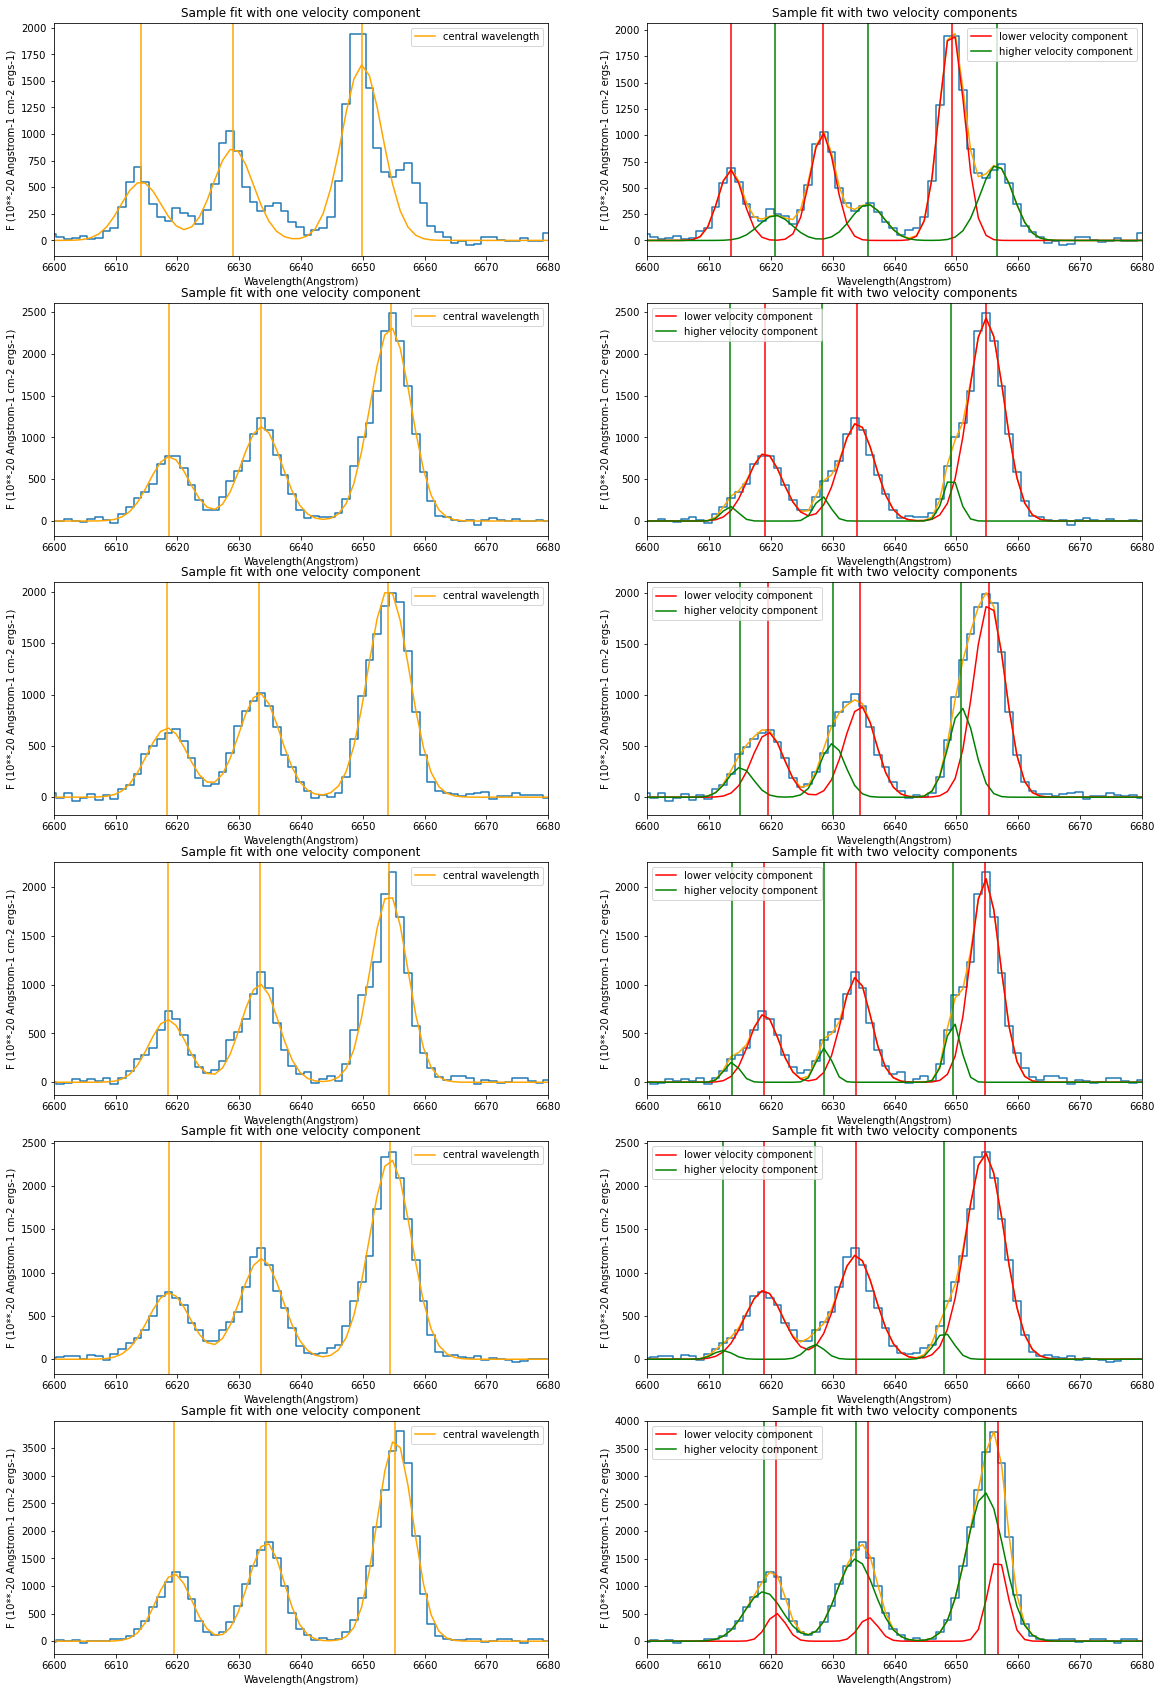

In [4]:
PIXELS = [(46,37), (56,33), (59,33), (57,32), (56,34), (59,36)]
ha_nii.plot_eval(PIXELS)

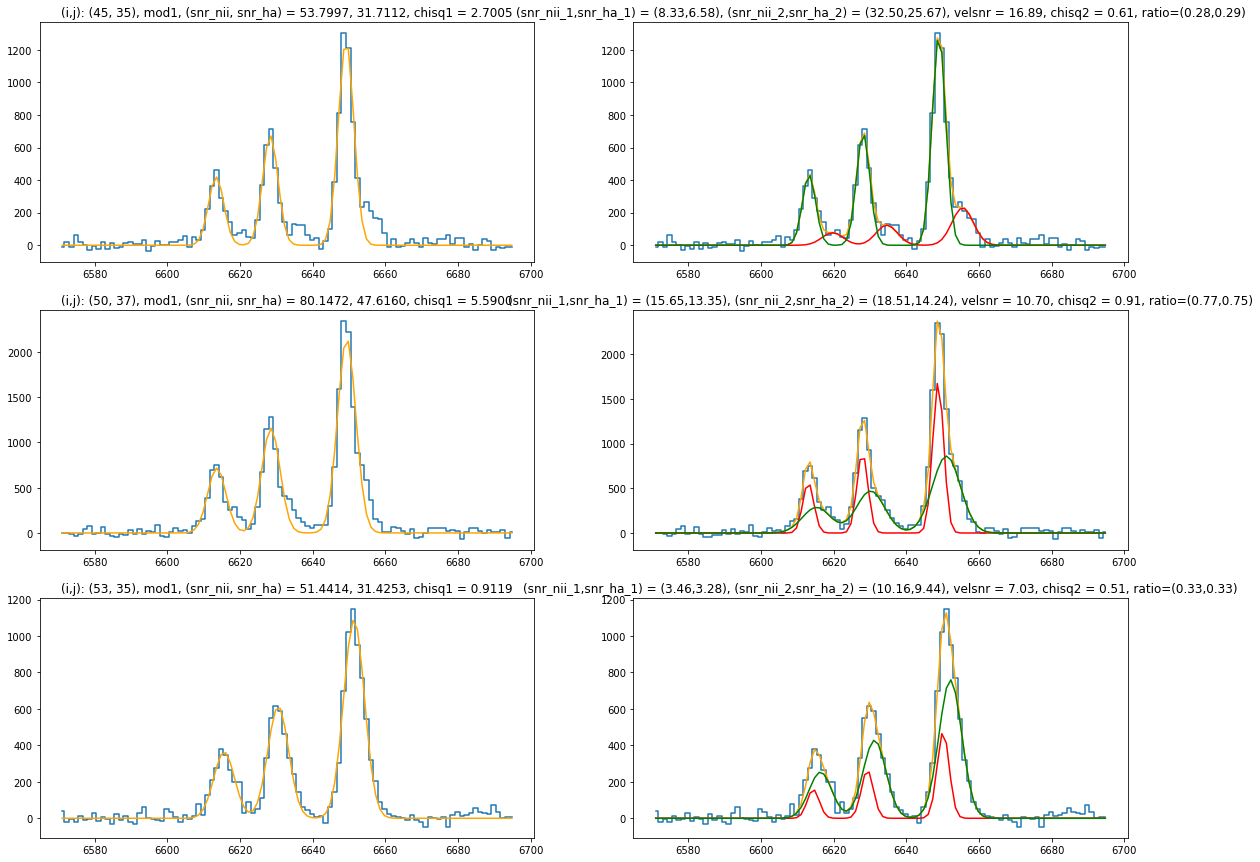

In [13]:
PIXELS = [(45,35), (50,37), (53,35)]
ha_nii.plot_eval(PIXELS)

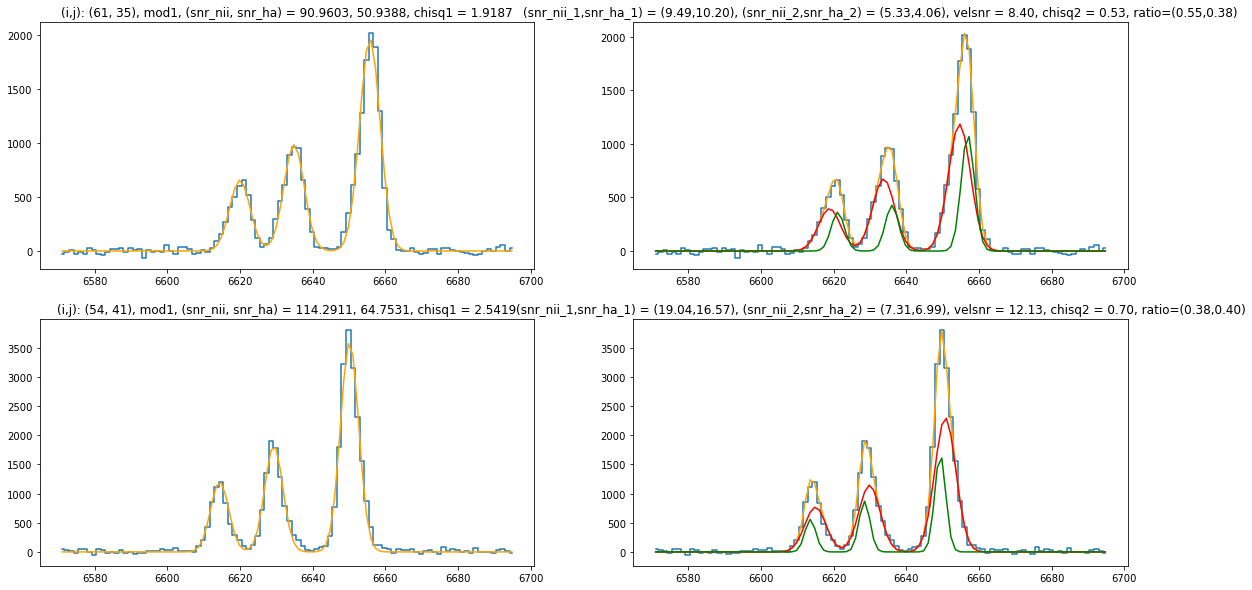

In [10]:
PIXELS = [(61,35), (54,41)]
ha_nii.plot_eval(PIXELS)

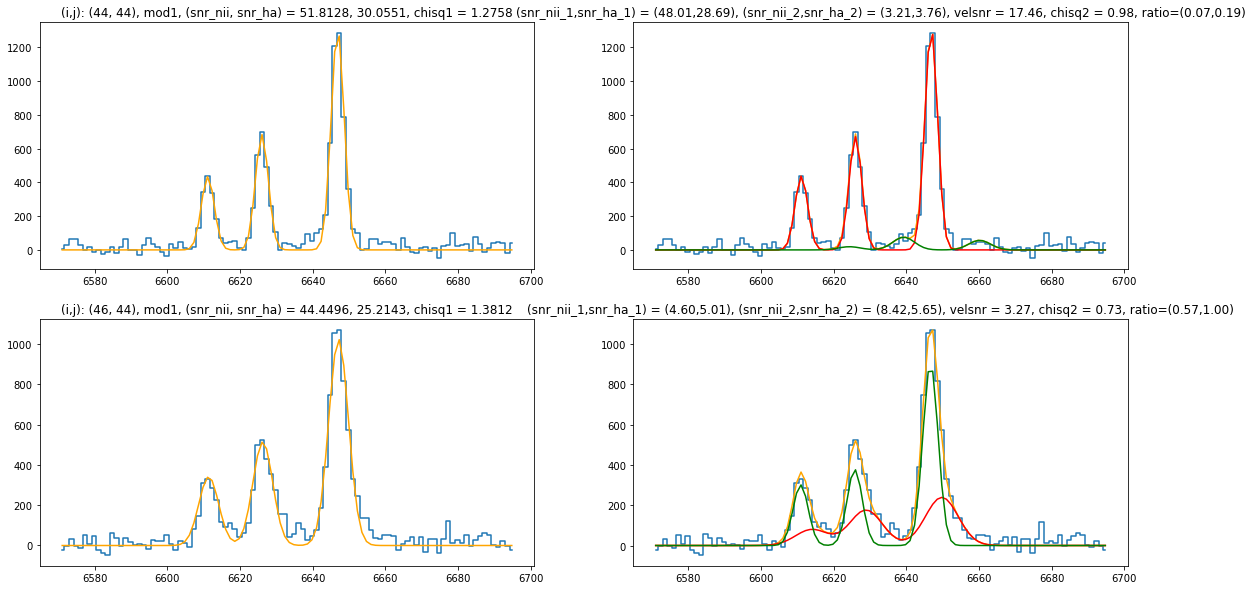

In [23]:
PIXELS = [(44,44),(46,44)]
ha_nii.plot_eval(PIXELS)

In [4]:
select_img = np.full((ha_nii.cube_x, ha_nii.cube_y), np.nan)
for i in tqdm(range(ha_nii.cube_x), smoothing=1):
    for j in range(ha_nii.cube_y):
       select_img[i,j] = ha_nii.component_sort(i,j)

#Save the 2 cubes
newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
# prihdu = fits.PrimaryHDU(ha_nii.mod1_fitcube[0], header=newhead)
# newsiihdus = [fits.ImageHDU(ha_nii.mod1_fitcube[i])
#                             for i in range(1, ha_nii.mod1_fitcube.shape[0])]
# siierrhdus = [fits.ImageHDU(ha_nii.mod1_fiterrcube[i])
#               for i in range(ha_nii.mod1_fiterrcube.shape[0])]
# hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
# hdul.writeto('../Ha_NII_fit/ha_nii_rebin_fit_mod1_select_ratio.fits', overwrite=True)

prihdu = fits.PrimaryHDU(ha_nii.mod2_fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.mod2_fitcube[i])
                            for i in range(1, ha_nii.mod2_fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.mod2_fiterrcube[i])
              for i in range(ha_nii.mod2_fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/Combine/ha_nii_rebin_fit_mod2_2_sort_flux.fits', overwrite=True)


# evalhdus = fits.PrimaryHDU(select_img, header=newhead)
# hdul3 = fits.HDUList([evalhdus])
# hdul3.writeto('../Ha_NII_fit/ha_nii_rebin_select_ratio_0.05.fits', overwrite=True)

100%|██████████| 65/65 [00:00<00:00, 329.73it/s]


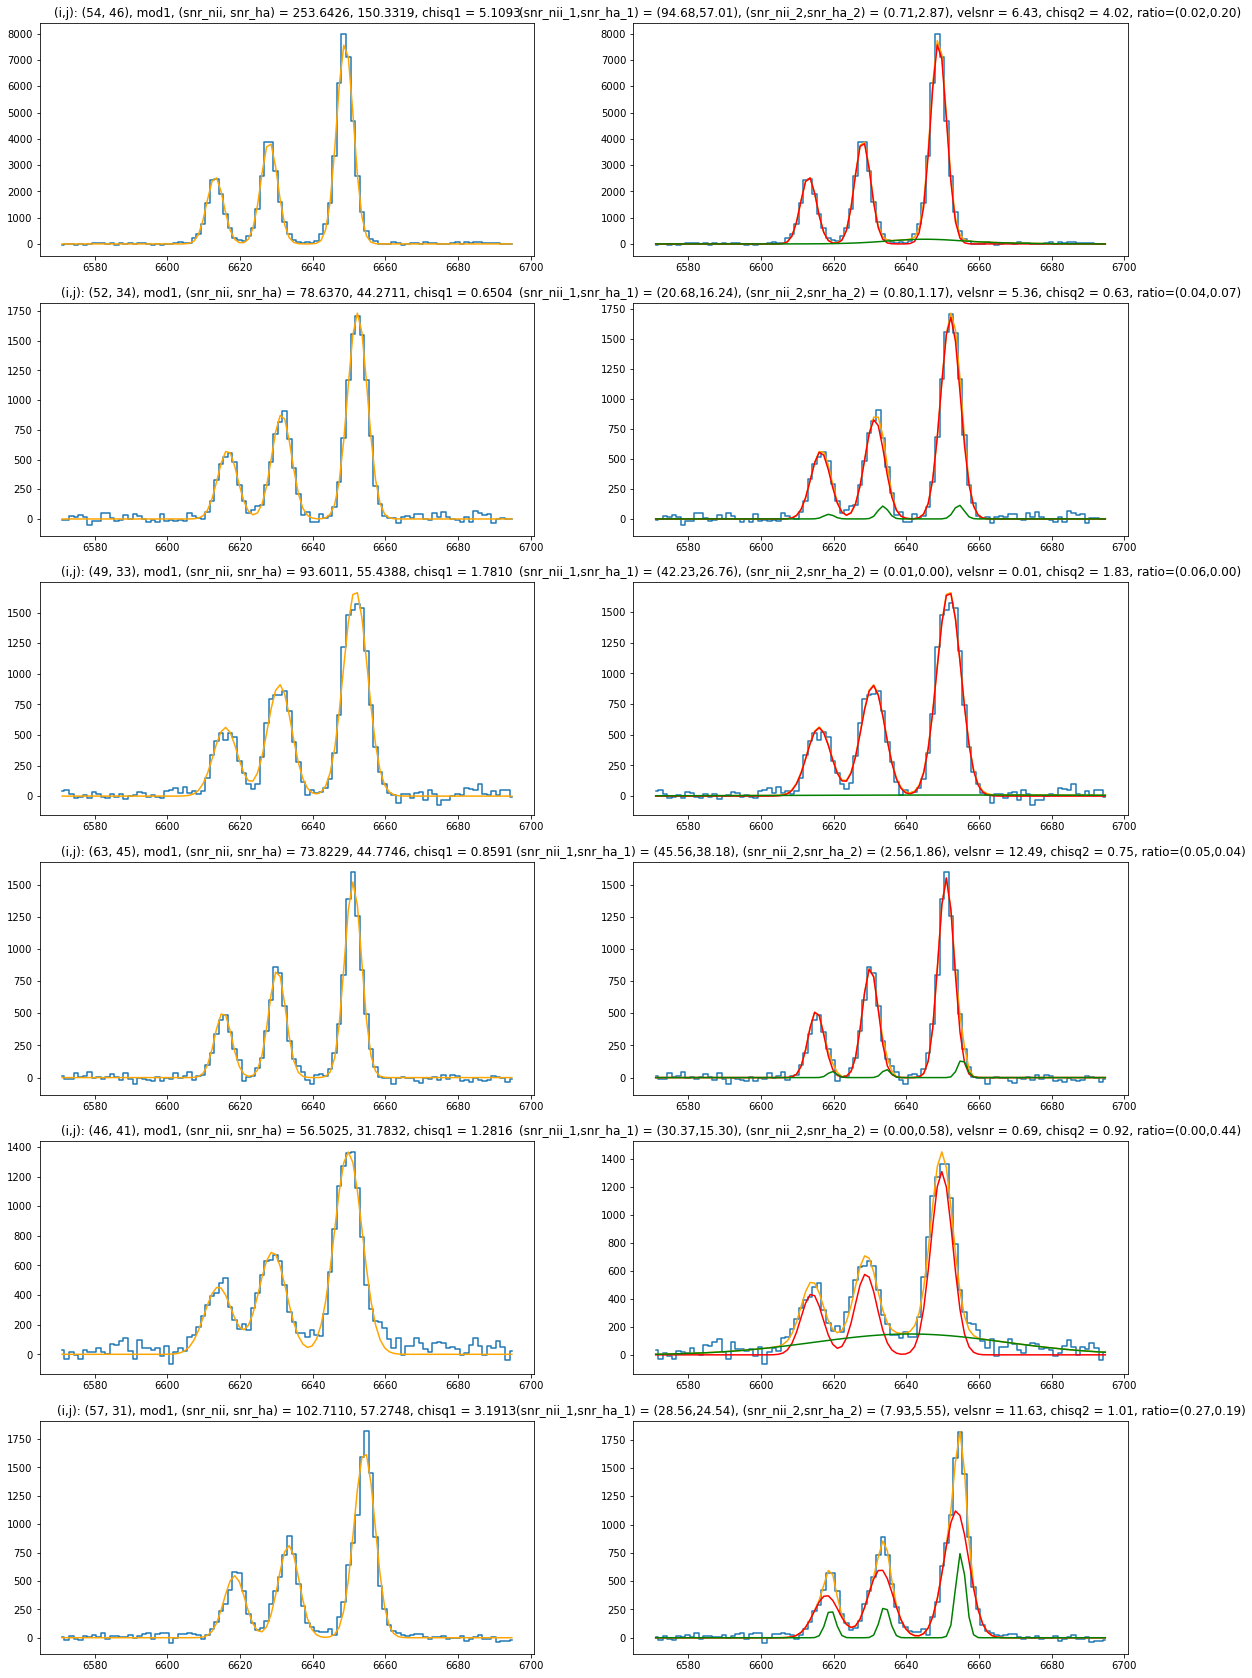

In [8]:
MOD2 = [ (54,46), (52,34), (49,33), (63,45), (46,41), (57,31)]
ha_nii.plot_eval(MOD2, save=False, fname='Ha_NII_mod2_compare')

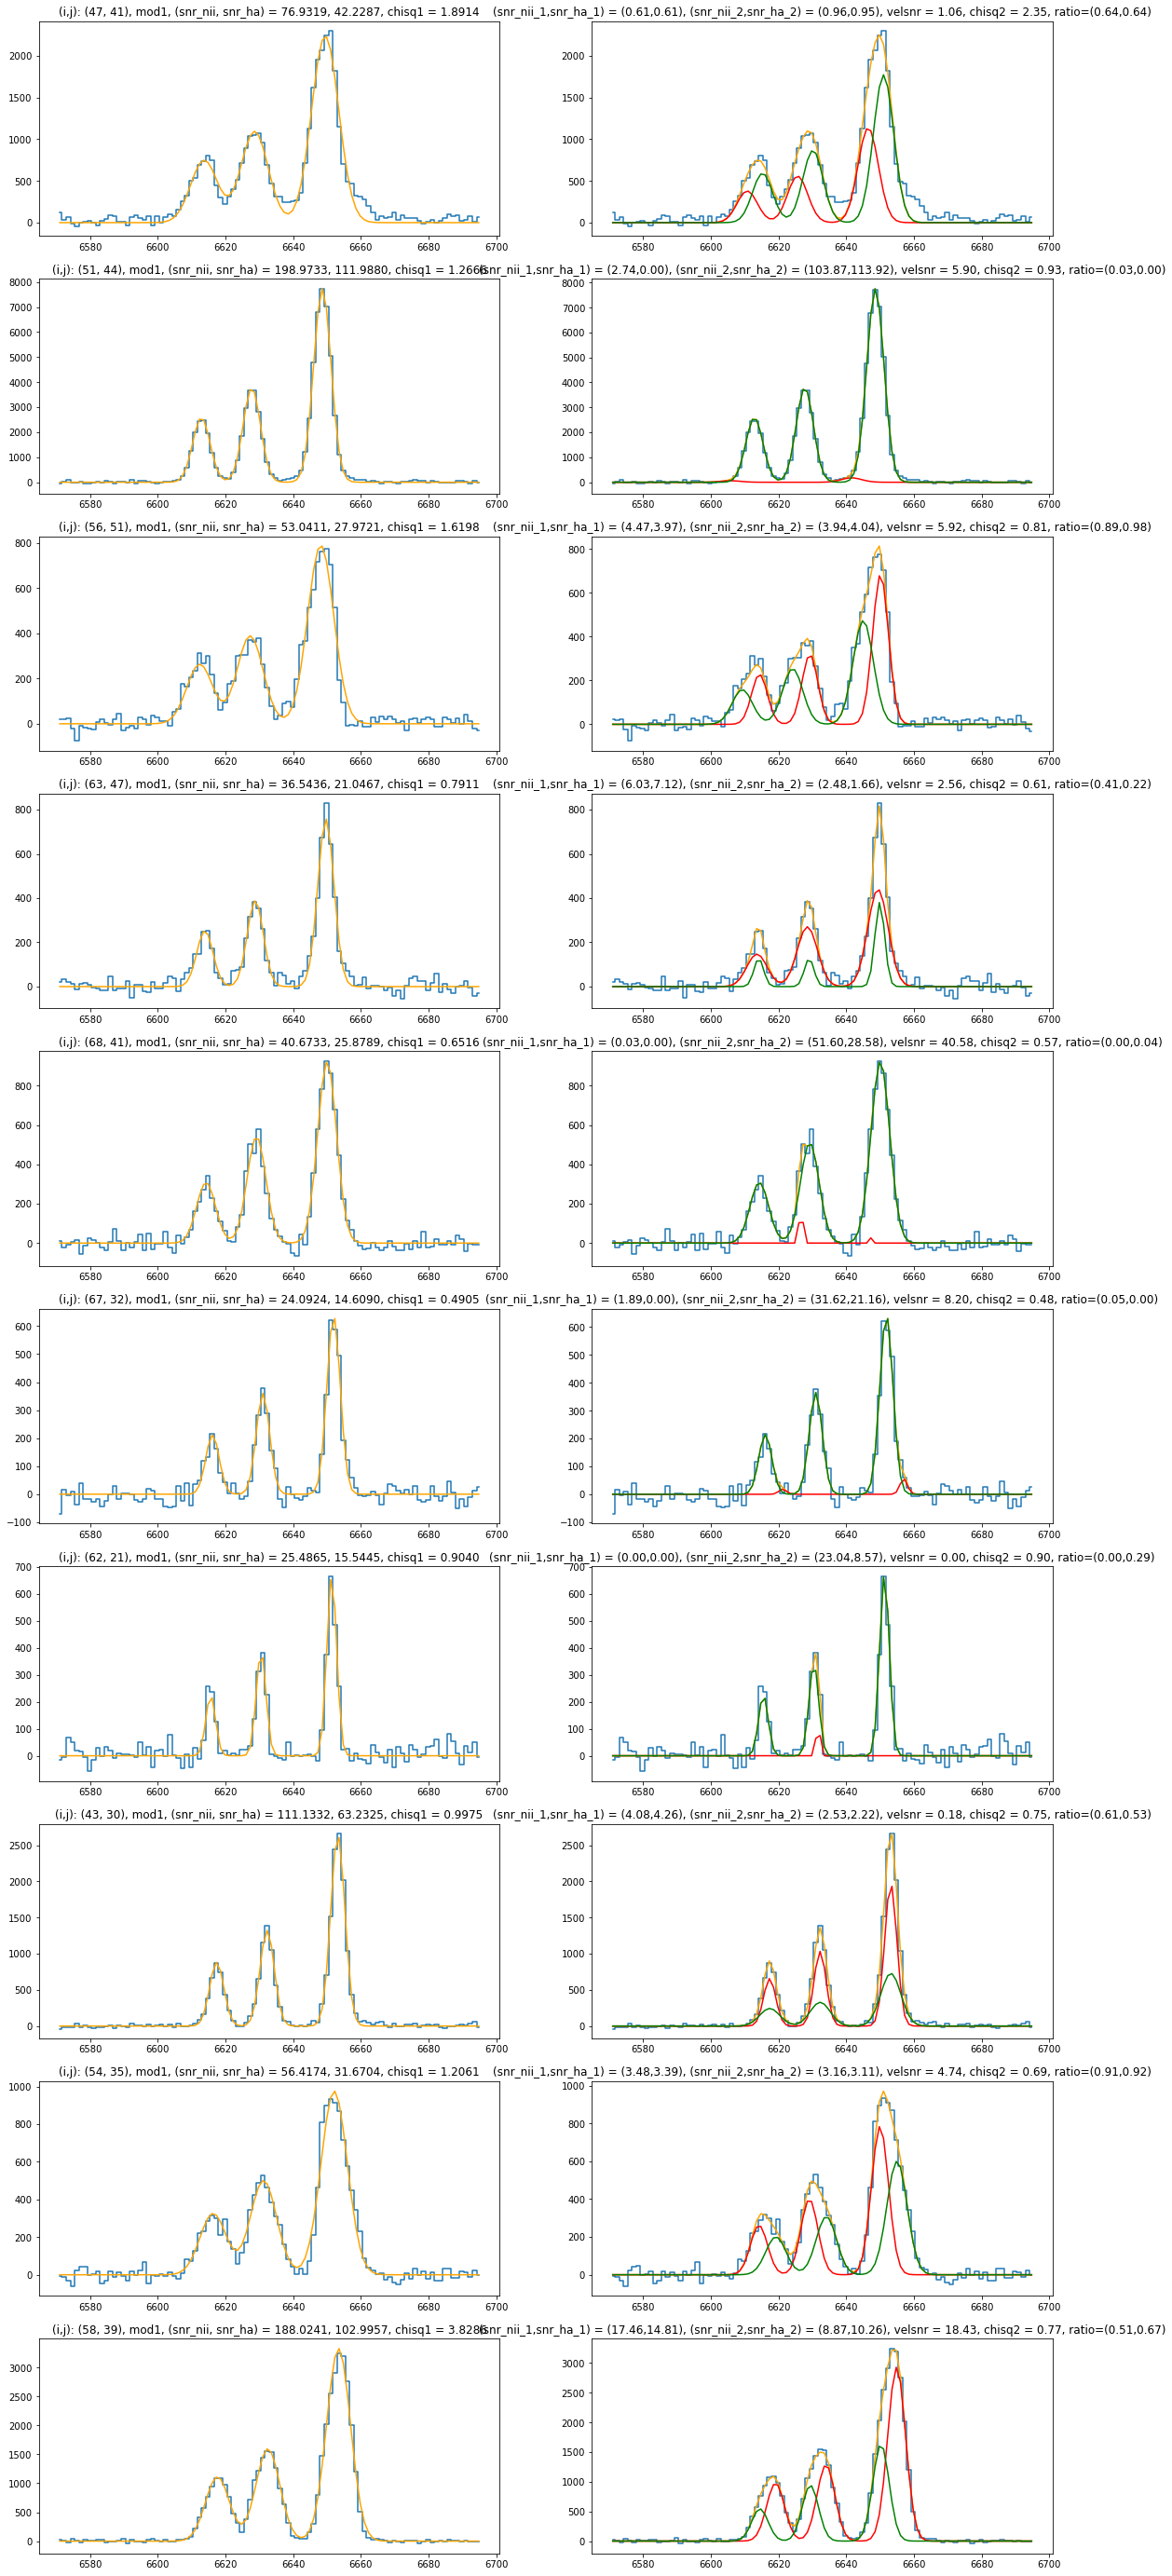

In [48]:
MOD1 = [(47,41), (51,44), (56,51), (63,47), (68,41), (67,32), (62,21), (43,30), (54,35), (58,39)]
ha_nii.plot_eval(MOD1, save=False, fname='Ha_NII_mod1_compare')

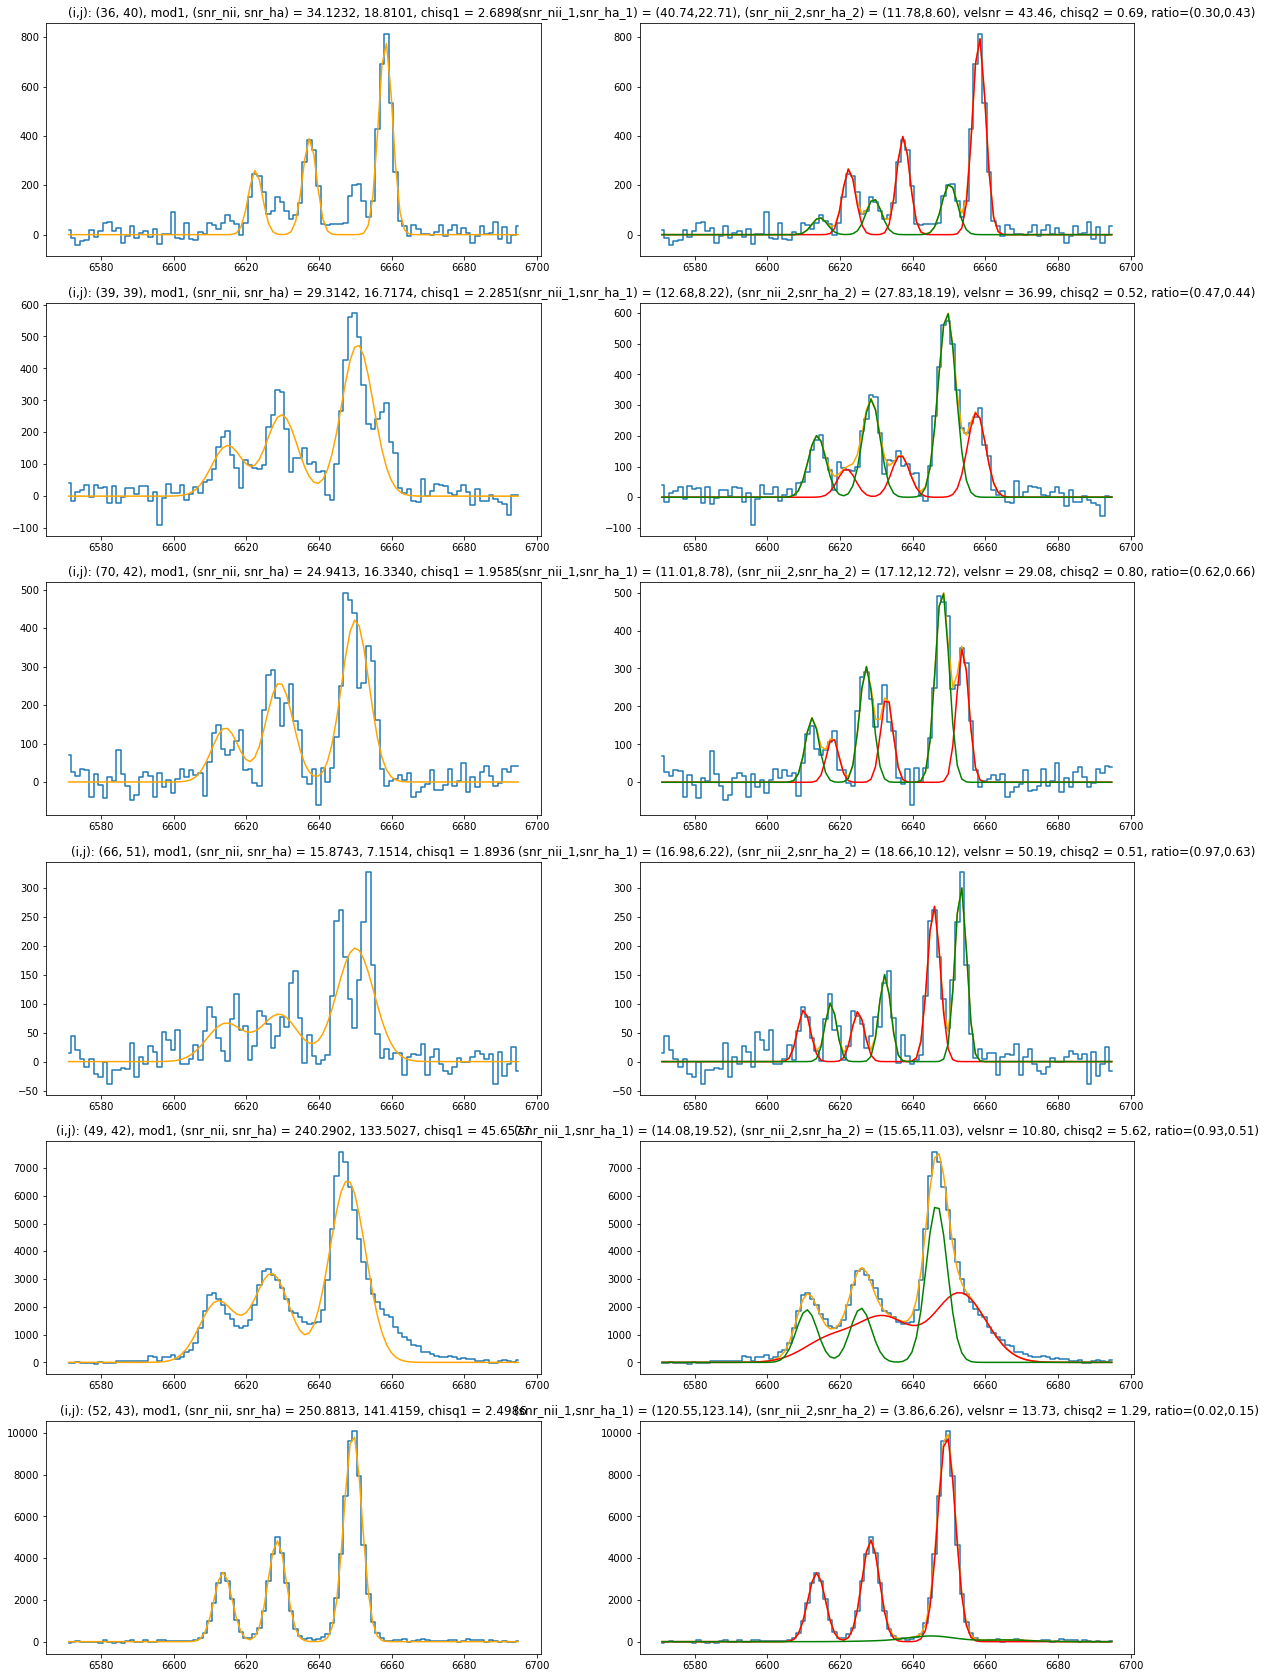

In [74]:
HIGH_VEL = [(36,40), (39,39), (70,42), (66,51), (49,42), (52,43)]
ha_nii.plot_eval(HIGH_VEL, save=False, fname='Ha_NII_HIGH_VEL')


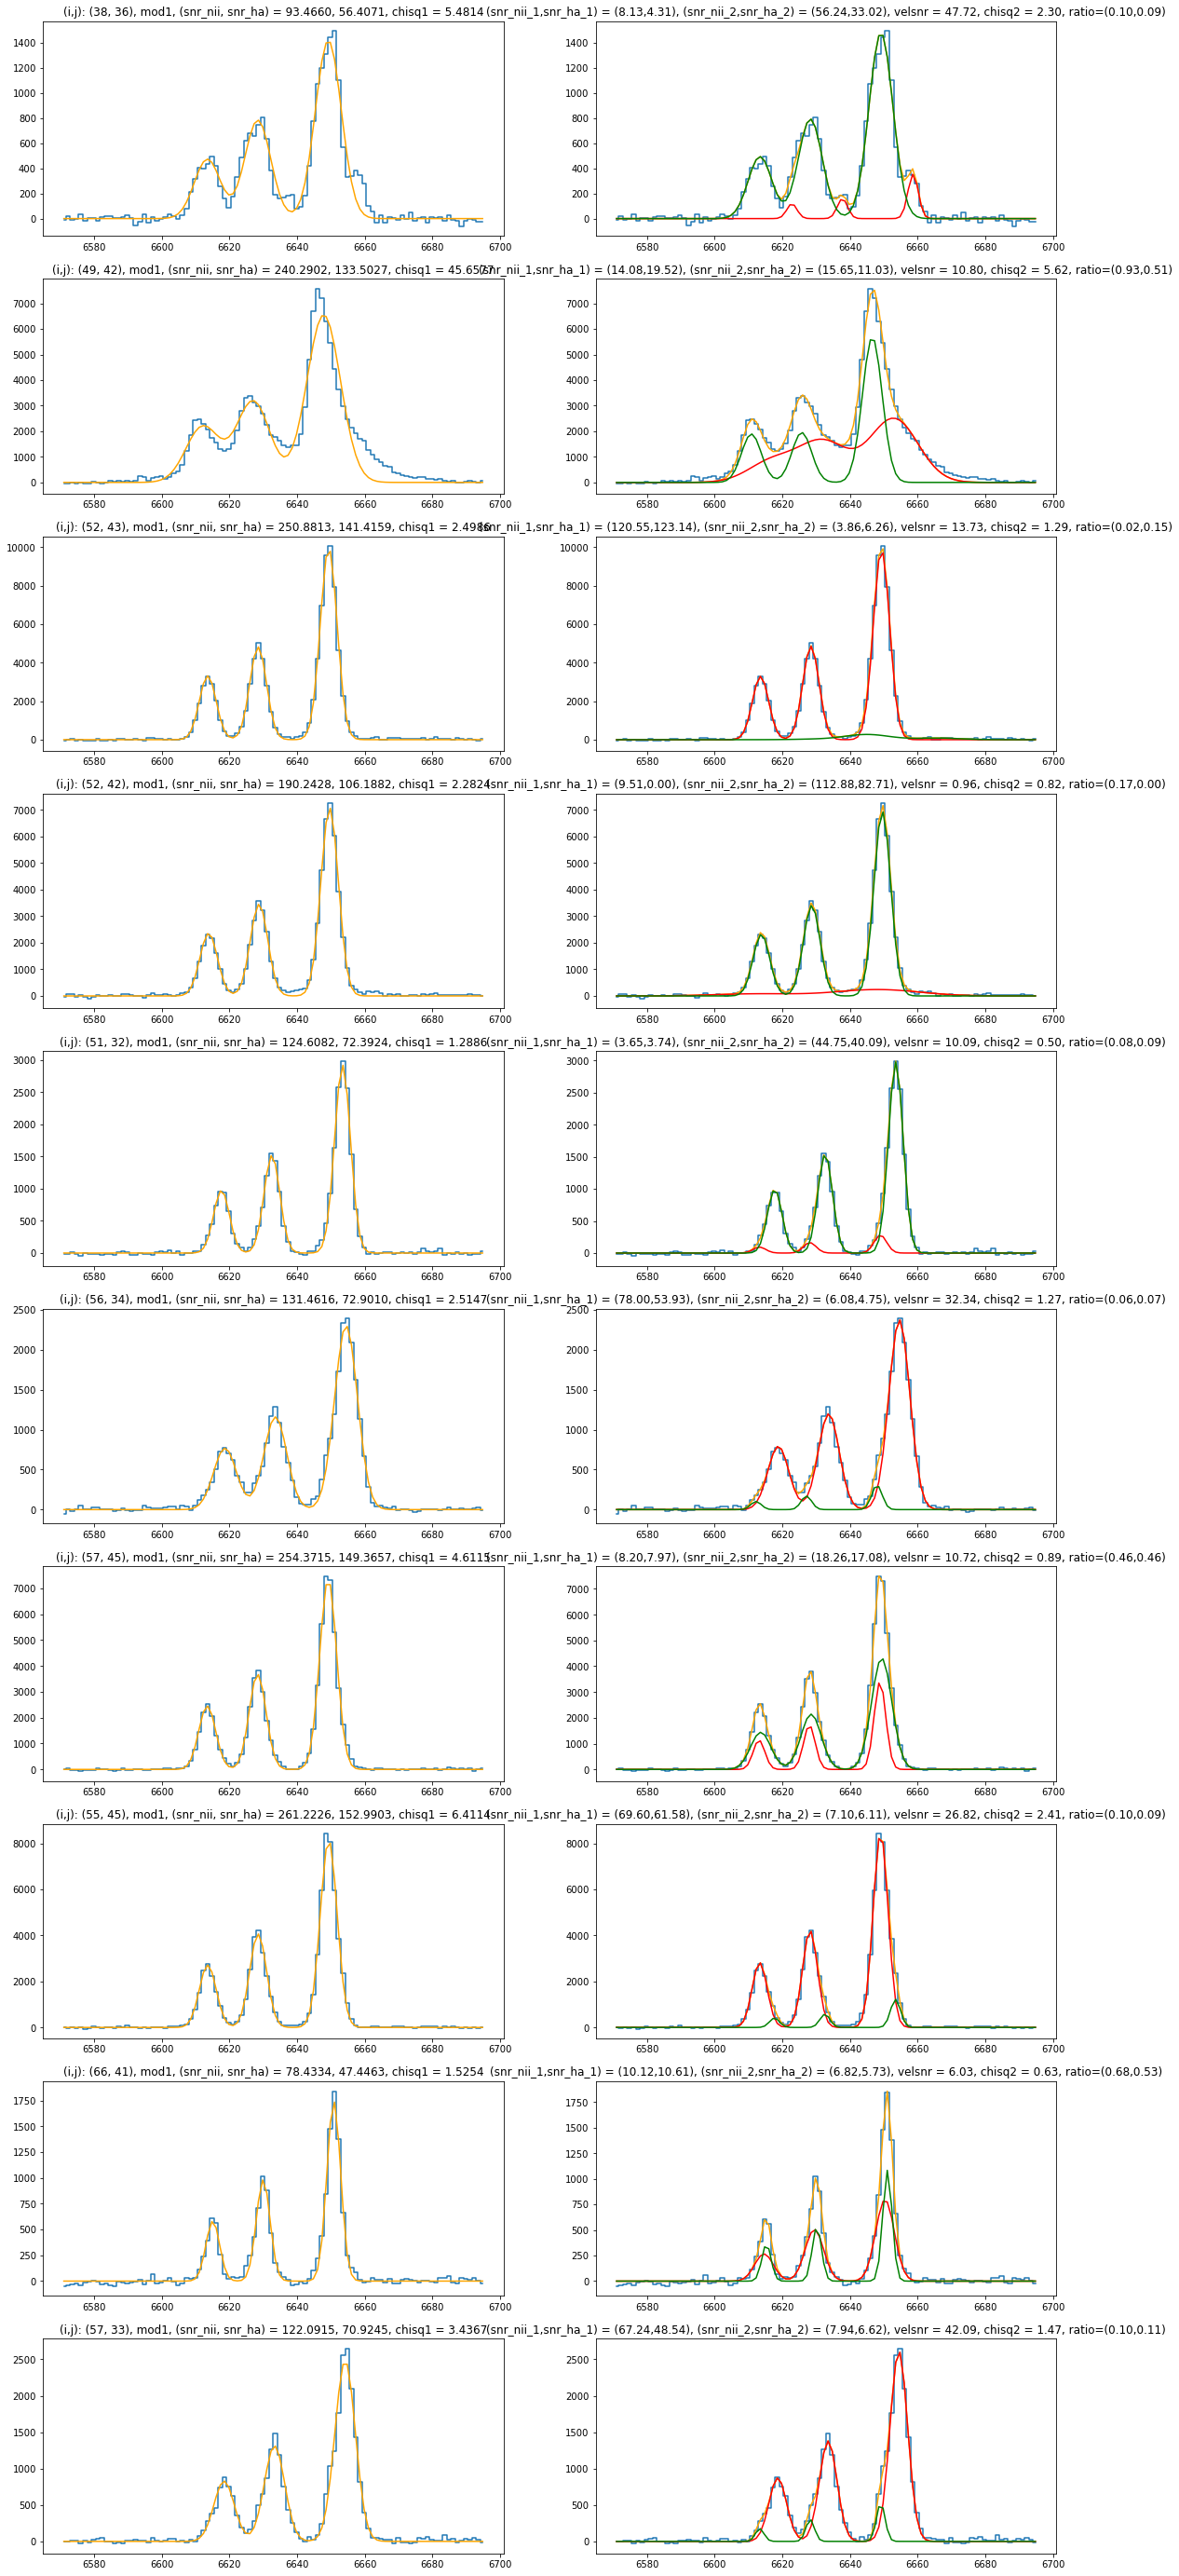

In [75]:
FLUX_REJ = [(38,36), (49,42), (52,43), (52,42), (51,32), (56,34), (57,45), (55,45), (66,41), (57,33)]
ha_nii.plot_eval(FLUX_REJ)

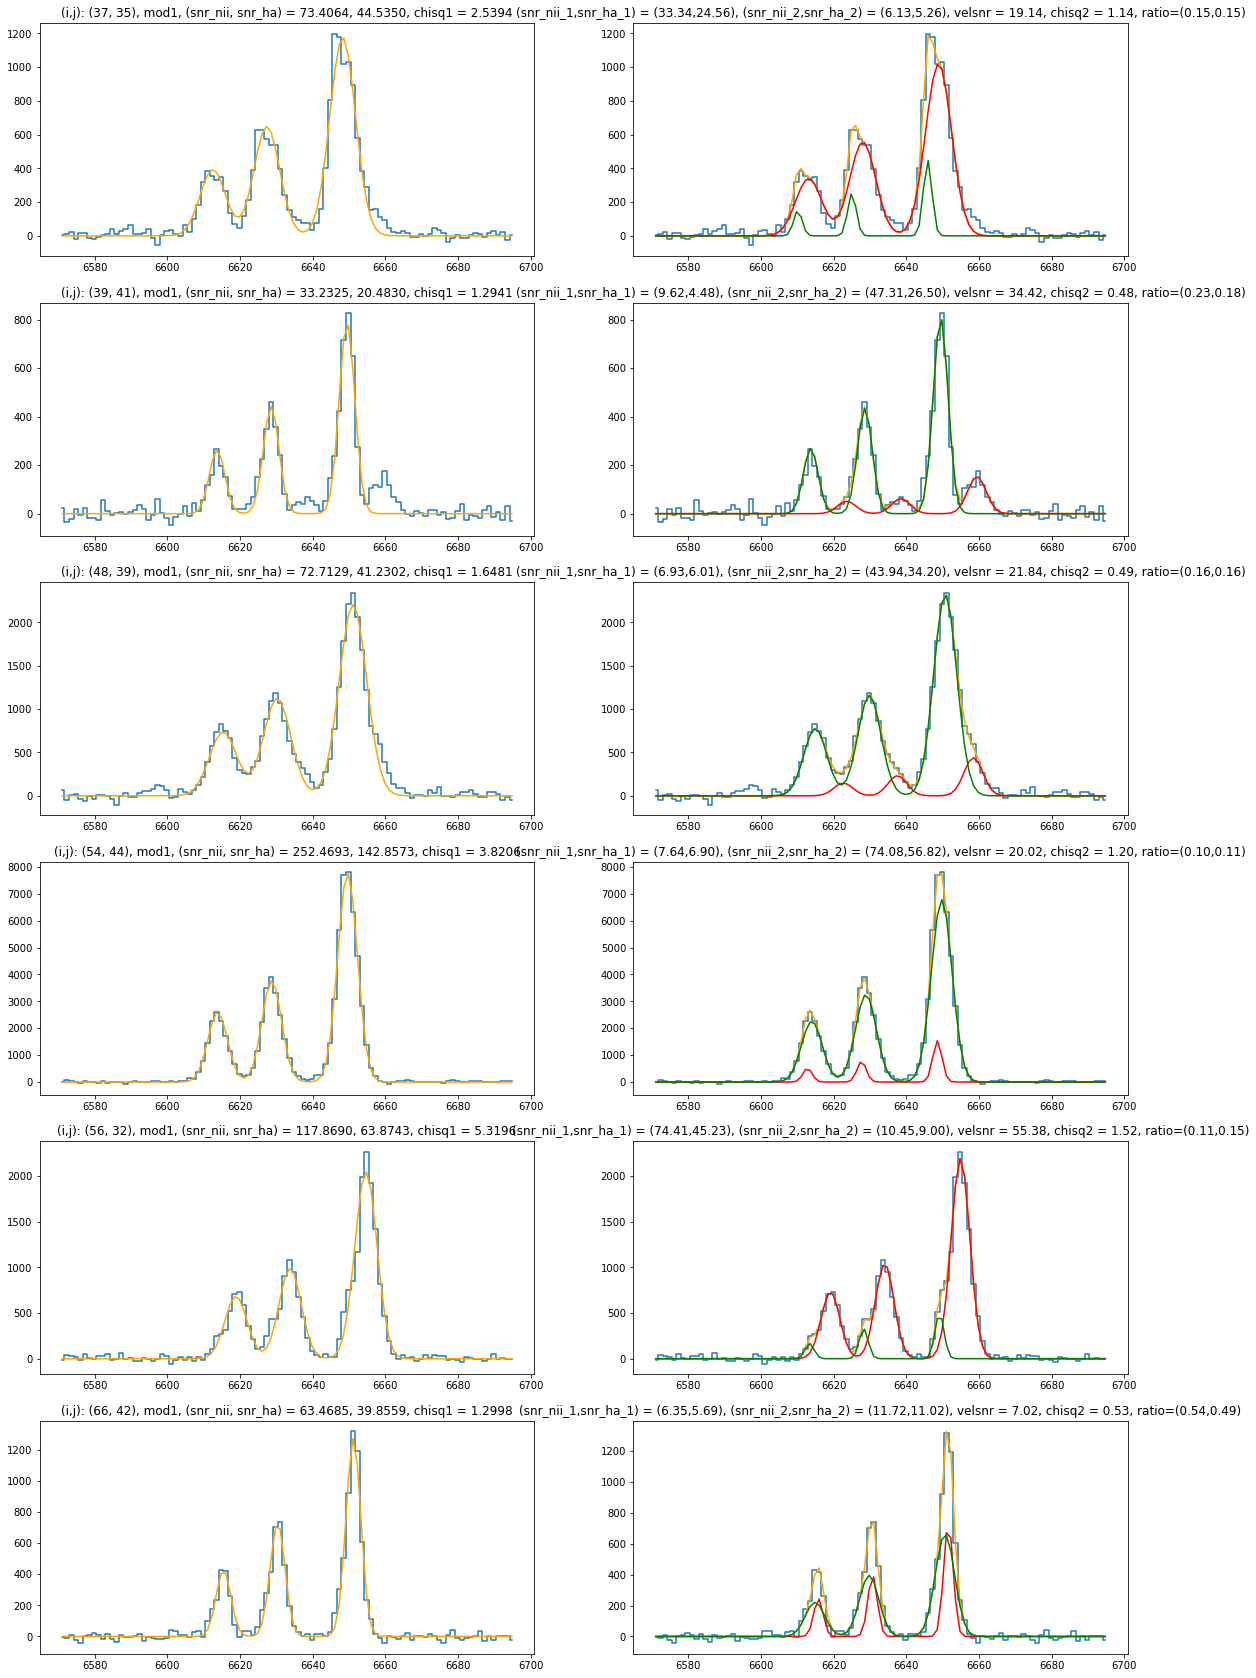

In [76]:
RATIO_COMP = [(37,35),(39,41), (48,39), (54,44), (56,32), (66,42)]
ha_nii.plot_eval(RATIO_COMP)

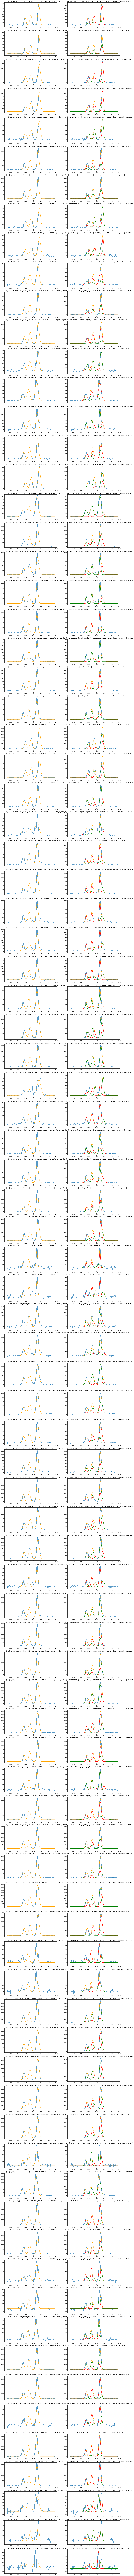

In [77]:
eval = fits.open("../Ha_NII_fit/select_2_4_comp.fits")[0].data
RATIO_EVAL = []
for i in range(eval.shape[0]):
    for j in range(eval.shape[1]):
        if eval[i,j] == -1:
            RATIO_EVAL.append((j+1, i+1))
ha_nii.plot_eval(RATIO_EVAL)